In [ ]:
# import basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score,confusion_matrix
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
#import finalised credit and bureau files
credit = pd.read_csv('/content/creditfinal3.csv')
bureau = pd.read_csv('/content/bureaufinal3.csv')
data = pd.read_csv('/content/application_train.csv')

In [ ]:
#initiating logistic regression model
model = LogisticRegression(C=0.1, max_iter=1000)

In [ ]:
#merge all the fields into a final train data
train_pluscredit= data.merge(credit, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
train_final = train_pluscredit.merge(bureau,left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

cat_df=train_final.select_dtypes('object') # filtered dataframe
cont_df=train_final.select_dtypes('float')
disc_df=train_final.select_dtypes('int')

#deal with the nans
new_cat_list = cat_df.fillna(cat_df.mode())
new_cont_list = cont_df.fillna(cont_df.mean())
new_disc_list = disc_df.fillna(disc_df.mode())

#get dummies for catergorical variables
dfcat=pd.get_dummies(new_cat_list,drop_first=True)

#final training datframe
new_data= pd.concat([dfcat,new_cont_list,new_disc_list],axis=1)

In [ ]:
EDA_data = pd.concat([dfcat,new_cont_list,new_disc_list],axis=1)

In [ ]:
EDA_data.corr()['TARGET']

NAME_CONTRACT_TYPE_Revolving loans   -0.030123
CODE_GENDER_M                         0.055270
CODE_GENDER_XNA                      -0.001666
FLAG_OWN_CAR_Y                       -0.020508
FLAG_OWN_REALTY_Y                    -0.004172
                                        ...   
REG_CITY_NOT_LIVE_CITY                0.038214
REG_CITY_NOT_WORK_CITY                0.050226
LIVE_CITY_NOT_WORK_CITY               0.034370
Unnamed: 0_x                          0.002821
Unnamed: 0_y                          0.002821
Name: TARGET, Length: 342, dtype: float64

[Text(0.5, 1.0, 'Count of Default/Non-Default Cases')]

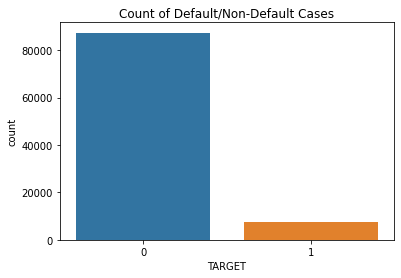

In [ ]:
sns.countplot(x='TARGET', data= EDA_data).set(title='Count of Default/Non-Default Cases')

In [ ]:
EDA_data['Years_Employed'] = (EDA_data['DAYS_EMPLOYED']/365)*-1

In [ ]:
#making sure there are no other remnants of the y variable in new_data
Target_columns = [col for col in new_data.columns if 'TARGET' not in col]
new_data = new_data[Target_columns]

In [ ]:
#fitting the model into X and y
X = new_data
y = data['TARGET']
print(X.shape, y.shape)

(95053, 341) (95053,)


In [ ]:
#baseline model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.33, random_state=42, stratify=y)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

Summary = {'Accuracy_test':[model.score(X_test,y_test)],'ROC_train':[roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])],'ROC_test':[roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])], 'Recall':[recall_score(y_test, y_pred)], 'Precision':[precision_score(y_test, y_pred)]}
Summary_df = pd.DataFrame(Summary)
print(Summary_df)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   Accuracy_test  ROC_train  ROC_test    Recall  Precision
0       0.919153   0.640755  0.638913  0.000394        0.5


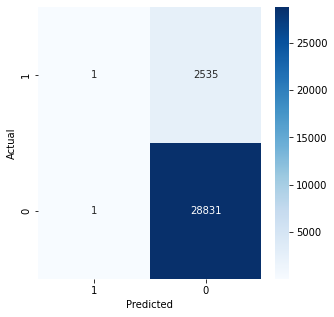

In [ ]:
#code to print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_pred), index = np.unique(y_pred))
plt.figure(figsize = (5,5))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
ax = sns.heatmap(df_cm, cmap="Blues",annot=True, fmt=".0f")
ax.invert_yaxis()
ax.invert_xaxis()

In [ ]:
#improving the model via minmax scaler
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_train_scaled = minmax.fit_transform(X_train)
X_test_scaled = minmax.transform(X_test)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

Summary = {'Accuracy_test':[model.score(X_test_scaled,y_test)],'ROC_train':[roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1])],'ROC_test':[roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])], 'Recall':[recall_score(y_test, y_pred)], 'Precision':[precision_score(y_test, y_pred)]}
Summary_df = pd.DataFrame(Summary)
print(Summary_df)

   Accuracy_test  ROC_train  ROC_test   Recall  Precision
0       0.918898   0.758851  0.744644  0.01735   0.458333


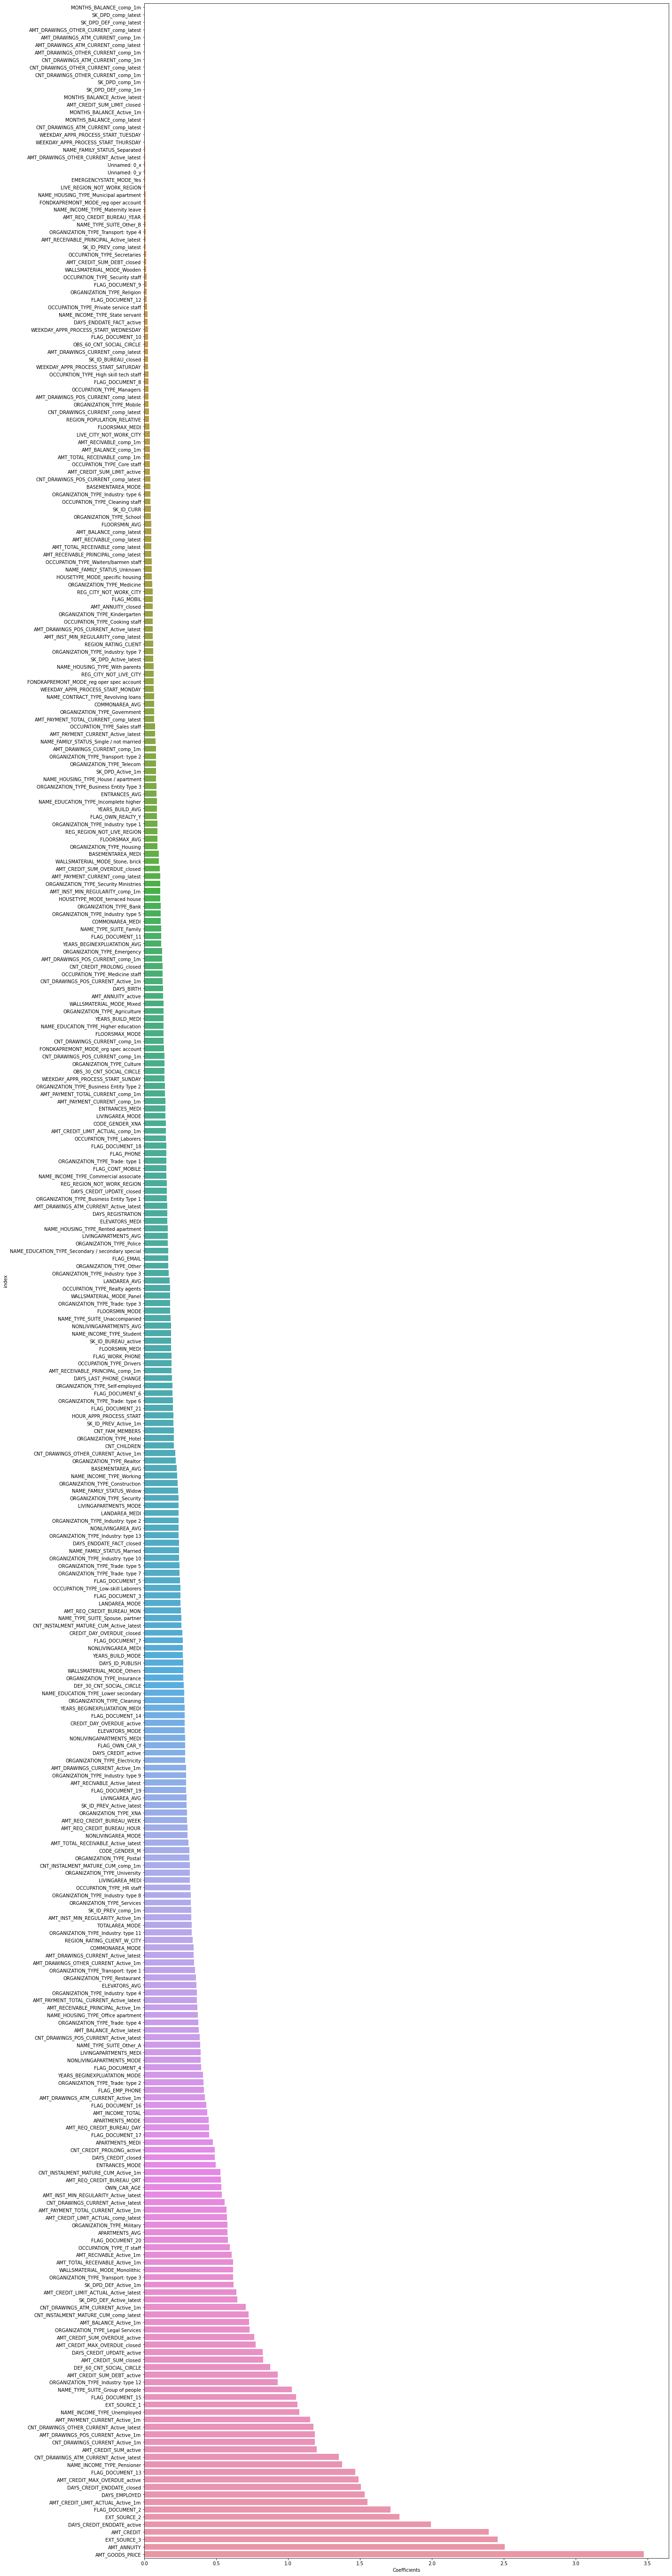

In [ ]:
#Ranking all the factors by feature importance
coefs = pd.DataFrame(
   model.coef_.T,
   columns=['Coefficients'], index=X_train.columns
)
coefs.reset_index(inplace=True)
coefs.Coefficients = coefs.Coefficients.abs()
coefs = coefs.sort_values(by='Coefficients')
plt.figure(figsize=(20,100))
sns.barplot(y='index', x='Coefficients', data= coefs)

In [ ]:
#putting the 6 most important factors into a list
final_list = coefs.nlargest(6, "Coefficients")['index'].to_list()
print(final_list)

['AMT_GOODS_PRICE', 'AMT_ANNUITY', 'EXT_SOURCE_3', 'AMT_CREDIT', 'DAYS_CREDIT_ENDDATE_active', 'EXT_SOURCE_2']


In [ ]:
new_data_6 = new_data[final_list]

In [ ]:
#train test split the smaller dataset
X_train, X_test, y_train, y_test = train_test_split(new_data_6, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
#scale the smaller dataset
X_train_scaled = minmax.fit_transform(X_train)
X_test_scaled = minmax.transform(X_test)

In [ ]:
#Getting a higher precision score with less variables
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

Summary = {'Accuracy_test':[model.score(X_test_scaled,y_test)],'ROC_train':[roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1])],'ROC_test':[roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])], 'Recall':[recall_score(y_test, y_pred)], 'Precision':[precision_score(y_test, y_pred)]}
Summary_df = pd.DataFrame(Summary)
print(Summary_df)

   Accuracy_test  ROC_train  ROC_test    Recall  Precision
0       0.919185   0.717262  0.710333  0.001183        0.6


In [ ]:
# now lets try polynomial and create some new features to see if the score improves. 
poly = PolynomialFeatures()
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

x_training = X_train_scaled_poly
x_testing = X_test_scaled_poly
model.fit(x_training, y_train)
y_pred = model.predict(x_testing)
y_train_pred = model.predict(x_training)

Summary = {'Accuracy_test':[model.score(x_testing,y_test)],'ROC_train':[roc_auc_score(y_train, model.predict_proba(x_training)[:, 1])],'ROC_test':[roc_auc_score(y_test, model.predict_proba(x_testing)[:, 1])], 'Recall':[recall_score(y_test, y_pred)], 'Precision':[precision_score(y_test, y_pred)]}
Summary_df = pd.DataFrame(Summary)
print(Summary_df)


   Accuracy_test  ROC_train  ROC_test  Recall  Precision
0       0.919153   0.719388  0.711684     0.0        0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# finding the best threshold for logit model

from sklearn.metrics import accuracy_score
probability_range = np.linspace(0,1,11)
Prob_stats = pd.DataFrame()

for i in probability_range:
  y_pred_proba = model.predict_proba(x_testing)[:,1]
  y_pred_adj = [1 if x > i else 0 for x in y_pred_proba]
  Summary = {'Accuracy_test':[accuracy_score(y_test, y_pred_adj)],'ROC_test':[roc_auc_score(y_test, y_pred_adj)], 'Recall':[recall_score(y_test, y_pred_adj)]}
  Summary_df = pd.DataFrame(Summary)
  Summary_df['proba'] = i
  Prob_stats = pd.concat([Prob_stats, Summary_df], axis=0)


In [ ]:
print(Prob_stats)

   Accuracy_test  ROC_test    Recall  proba
0       0.080847  0.500000  1.000000    0.0
0       0.736260  0.651537  0.550473    0.1
0       0.891992  0.577112  0.201498    0.2
0       0.915360  0.521672  0.052050    0.3
0       0.919090  0.502303  0.005126    0.4
0       0.919153  0.500000  0.000000    0.5
0       0.919153  0.500000  0.000000    0.6
0       0.919153  0.500000  0.000000    0.7
0       0.919153  0.500000  0.000000    0.8
0       0.919153  0.500000  0.000000    0.9
0       0.919153  0.500000  0.000000    1.0


[[27469  1363]
 [ 2025   511]]


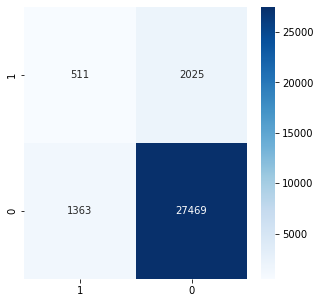

In [ ]:
#Using proba of 0.1 given highest ROC test score
y_pred = [1 if x > 0.2 else 0 for x in y_pred_proba]
cm = confusion_matrix(y_test, y_pred)

print(cm)

plt.figure(figsize = (5,5))
ax = sns.heatmap(cm, cmap="Blues",annot=True, fmt=".0f")
ax.invert_yaxis()
ax.invert_xaxis()

In [ ]:
# Using KNN as an alternative model. 
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_training, y_train)
y_pred_neigh = neigh.predict(x_testing)
Summary = {'ROC':[roc_auc_score(y_test, y_pred_neigh)], 'Recall':[recall_score(y_test, y_pred_neigh)], 'Precision':[precision_score(y_test, y_pred_neigh)]}
Summary_df = pd.DataFrame(Summary)
print(Summary_df)

        ROC    Recall  Precision
0  0.518634  0.049685   0.260331


In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(max_depth=5)
RFC.fit(x_training, y_train)
y_pred_rfc = RFC.predict(x_testing)
Summary = {'ROC':[roc_auc_score(y_test, y_pred_rfc)], 'Recall':[recall_score(y_test, y_pred_rfc)], 'Precision':[precision_score(y_test, y_pred_rfc)]}
Summary_df = pd.DataFrame(Summary)
print(Summary_df)

        ROC    Recall  Precision
0  0.500754  0.001577   0.666667


In [ ]:
# Using SVM as an alternative model. 
from sklearn.svm import SVC
svc_model = SVC(kernel='poly')
svc_model.fit(x_training, y_train)
y_pred_neigh = svc_model.predict(x_testing)
Summary = {'ROC':[roc_auc_score(y_test, y_pred_neigh)], 'Recall':[recall_score(y_test, y_pred_neigh)], 'Precision':[precision_score(y_test, y_pred_neigh)]}
Summary_df = pd.DataFrame(Summary)
print(Summary_df)



   ROC  Recall  Precision
0  0.5     0.0        0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


APPENDIX

In [ ]:
#For visualising of coeffcients
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   model.coef_.T,
   columns=['Coefficients'], index=X_train.columns
)
coefs.reset_index(inplace=True)
coefs = coefs.sort_values(by='Coefficients')
print(coefs.shape)
print(coefs.head(5))
plt.figure(figsize=(20,200))
sns.barplot(y='index', x='Coefficients', data= coefs)

In [ ]:
#to plot the ROC CUrve
pred_prob1 = model3.predict_proba(X_test_poly_imp_sc)
print(pred_prob1)
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='With Regularisation')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [ ]:
# to do resampling
#smote does not really help AUC (0.69)
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X_train_imp = X_train
X_train_imp_smote, y_train_smote = oversample.fit_resample(X_train_imp, y_train)
X_train_poly_imp_sc = minmax.fit_transform(X_train_imp_smote)

X_test_sc = minmax.transform(X_test)
model = LogisticRegression()
model.fit(X_train_poly_imp_sc, y_train_smote)
y_pred_sc = model.predict(X_test_sc)

Summary = {'ROC':[roc_auc_score(y_test, model.predict_proba(X_test_sc)[:, 1])], 'Recall':[recall_score(y_test, y_pred_sc)], 'Precision':[precision_score(y_test, y_pred_sc)]}
Summary_df = pd.DataFrame(Summary)

print(Summary_df)

In [ ]:
# # load library
# from sklearn.svm import SVC

# # we can add class_weight='balanced' to add panalize mistake
# svc_model = SVC(kernel='linear')

# svc_model.fit(X_train_poly_imp_sc, y_train_smote)

# svc_predict = svc_model.predict(X_test_poly_imp_sc)# check performance
# print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
# print('Accuracy score:',accuracy_score(y_test, svc_predict))
# print('F1 score:',f1_score(y_test, svc_predict))

In [ ]:
# def eda(df, column):
#    df[column + '_Quar'] = pd.cut(df[column],4,labels=['1','2','3','4'])


# f = plt.figure(figsize=(20, 300)) #very big plain paper 


# s1 = int(round(len(cont_list)/8,0))
# print(s1)

# for i in range(0,len(cont_list)):
#     f.add_subplot(s1,4,i+1)
#     eda(new_data, cont_list[i])

In [ ]:

# for i in range(0,len(cont_list)):
#     eda(new_data, cont_list[i])

# for i in range(0, len(data.columns)):
#     z = data.columns[i]
#     baseline = data[z].value_counts(normalize=True)
#     baseline = baseline.mul(100)
#     baseline = pd.DataFrame(baseline).reset_index()
#     baseline = baseline.rename(columns={z:'percent', 'index':z})
#     baseline['Default'] = 'Baseline'
#     a = data.groupby('TARGET')[z].value_counts(normalize=True)
#     a = a.mul(100)
#     a = a.rename('percent').reset_index()
#     a['Default'] = a['TARGET'].map({1:'Default', 0:'No Default'})
#     b = pd.concat([baseline, a], axis=0)
#     g = sns.catplot(x='Default',y='percent',hue=z',kind='bar', data=b)
#     g.ax.set_ylim(0,100)
#     ax = g.facet_axis(0, 0)
#     for c in ax.containers:
#         labels = [f'{(v.get_height()):.1f}%' for v in c]
#         ax.bar_label(c, labels=labels, label_type='edge')
# def eda(df, df2 , column):
#     df2[column + '_Quar'] = pd.cut(df[column],4,labels=['1','2','3','4'])
#     sns.countplot(x=column + '_Quar', hue='TARGET',data=df)

Pop_percent = data.groupby('TARGET').value_counts(normalize=True)
Pop_percent = Pop_percent.mul(100)
Pop_percent = Pop_percent.rename('percent').reset_index()
g = sns.catplot(x='TARGET',y='percent',kind='bar', data=Pop_percent)
g.ax.set_ylim(0,100)
a = data.groupby('TARGET')['CODE_GENDER'].value_counts(normalize=True)
a = a.mul(100)
a = a.rename('percent').reset_index()
g = sns.catplot(x='TARGET',y='percent',hue='CODE_GENDER',kind='bar', data=a)
g.ax.set_ylim(0,100)


g = sns.catplot(x='CODE_GENDER',y='percent',hue='CODE_GENDER',kind='bar', data=a)
# #Catergorical Variables
# f = plt.figure(figsize=(20, 20)) #very big plain paper 

# s1 = int(round(len(cat_list)/8,0))
# print(s1)

# for i in range(0,len(cat_list)):
#     f.add_subplot(s1,4,i+1)
#     sns.countplot(x=cat_list[i], hue='TARGET',data=data)
#     plt.xticks(rotation=90)


In [ ]:
#code to check how many variables to run

for i in range(1,40):
    newlist = coefs.nlargest(i, "Coefficients")['index'].to_list()
    no_coeffs.append(i)
    X_train_clean = X_train[newlist]
    X_test_clean = X_test[newlist]
    X_train_clean_poly = poly.fit_transform(X_train_clean)
    X_test_clean_poly = poly.transform(X_test_clean)
    X_train_clean_sc = minmax.fit_transform(X_train_clean_poly)
    X_test_clean_sc = minmax.transform(X_test_clean_poly)
    model.fit(X_train_clean_sc, y_train)
    y_pred_clean_sc = model.predict(X_test_clean_sc)
    ROC_AUC.append(roc_auc_score(y_test, model.predict_proba(X_test_clean_sc)[:, 1]))
    Recall.append(recall_score(y_test, y_pred_clean_sc))
    Summarydf = pd.DataFrame(zip(no_coeffs,ROC_AUC), columns=['no_coeffs','ROC_AUC'])
print(Summarydf)

In [ ]:
#massage the test data
data_test = pd.read_csv(r'C:\Users\user\Documents\application_test.csv')

test_pluscredit= data_test.merge(credit, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
test_final = test_pluscredit.merge(bureau,left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

cat_test=test_final.select_dtypes('object') # filtered dataframe
cont_test=test_final.select_dtypes('float')
disc_test=test_final.select_dtypes('int')

test_cat_list = cat_test.fillna(cat_test.mode())
test_cont_list = cont_test.fillna(cont_test.mean())
test_disc_list = disc_test.fillna(disc_test.mode())

dftest=pd.get_dummies(test_cat_list,drop_first=True)
test_data= pd.concat([dftest,test_cont_list,test_disc_list],axis=1)
print(test_data.shape)

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)
# X_train_pca = pca.fit_transform(X_train_scaled_poly)
# X_test_pca = pca.transform(X_test_scaled_poly)

# x_training = X_train_pca
# x_testing = X_test_pca
# model.fit(x_training, y_train)
# y_pred = model.predict(x_testing)
# y_train_pred = model.predict(x_training)

# Summary = {'Accuracy_test':[model.score(x_testing,y_test)],'ROC_train':[roc_auc_score(y_train, model.predict_proba(x_training)[:, 1])],'ROC_test':[roc_auc_score(y_test, model.predict_proba(x_testing)[:, 1])], 'Recall':[recall_score(y_test, y_pred)], 'Precision':[precision_score(y_test, y_pred)]}
# Summary_df = pd.DataFrame(Summary)
# print(Summary_df)

# print(pca.explained_variance_ratio_)

In [ ]:
g = sns.catplot(x='Default',y='percent',hue='Age_Year_Q',kind='bar', data=b, height=5, aspect=8.27/8.27).set(title='Age by Quartile')
g.ax.set_ylim(0,40)
ax = g.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()):.0f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')